# Neural Network implementation from scratch on MNSIT Dataset

In [38]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.17.0


## Data Loading

In [39]:
#
# This code cell is taken from Kaggle to read the MNSIT Data
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        



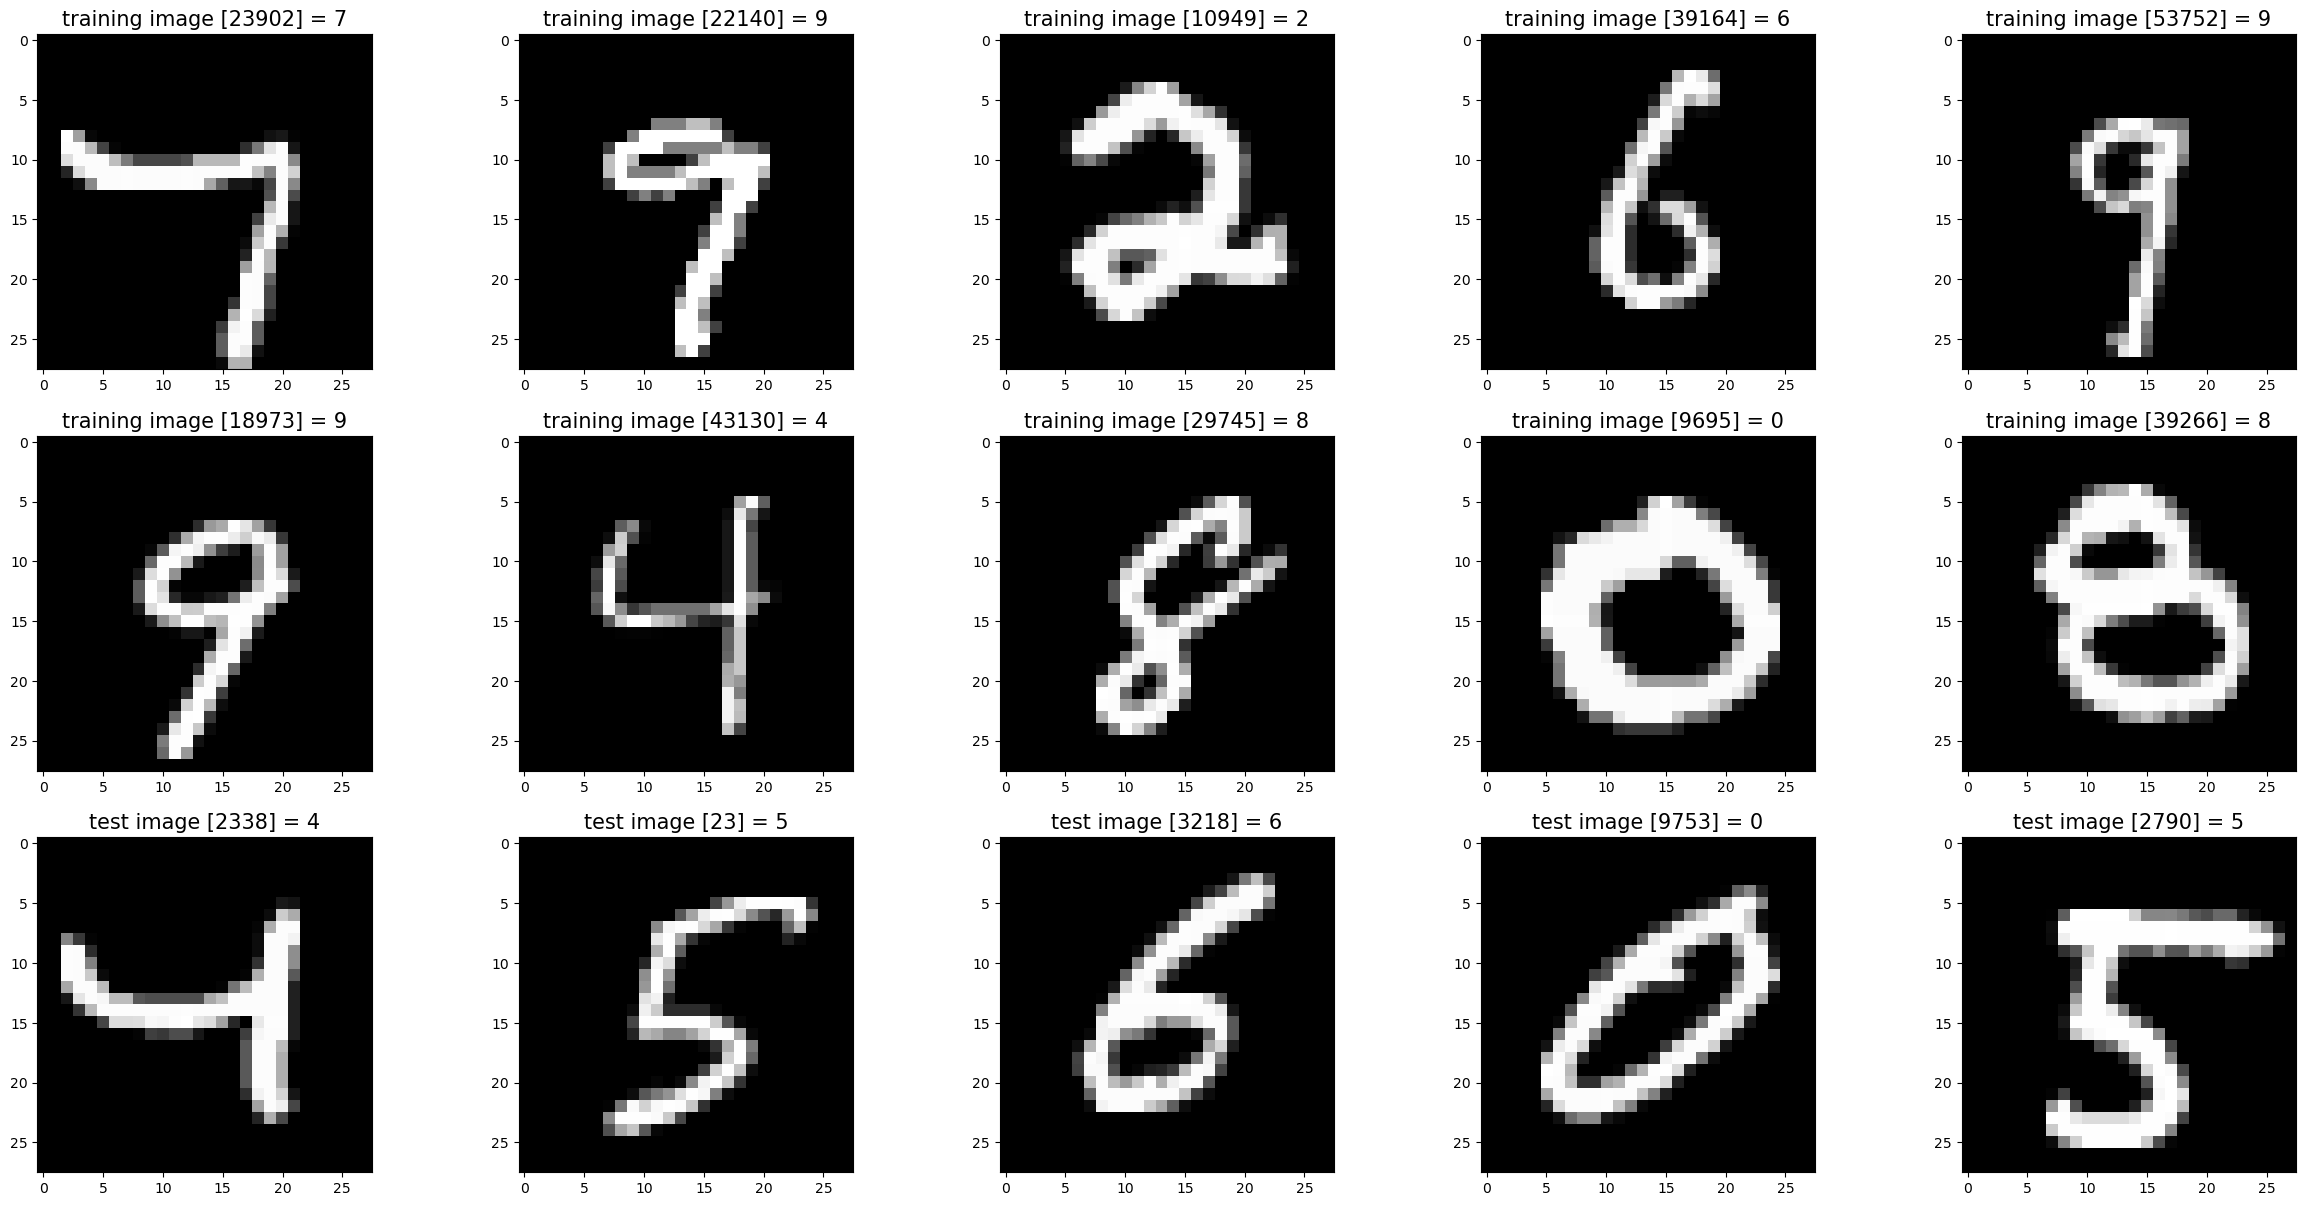

In [40]:
#
# This code cell is taken from Kaggle to read the MNSIT Data
#
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#First unzip the dataset
import zipfile
import os

# Path to the zip file and the directory to extract to
zip_path = './dataset.zip'
extract_to = './dataset'

# Create the directory if it does not exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
    
#
# Set file paths based on added MNIST Datasets
#   
input_path = './dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Data Preprocessing

X_train, X_test, y_train, y_test are lists, convert them to numpy arrays

In [41]:
type(x_train)

list

In [42]:
len(x_train), len(y_train), len(x_test), len(y_test)

(60000, 60000, 10000, 10000)

In [43]:
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)
y_train_one_hot.shape, y_test_one_hot.shape

((60000, 10), (10000, 10))

In [44]:
y_train_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [45]:
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
x_train_np.shape, x_test_np.shape

((60000, 28, 28), (10000, 28, 28))

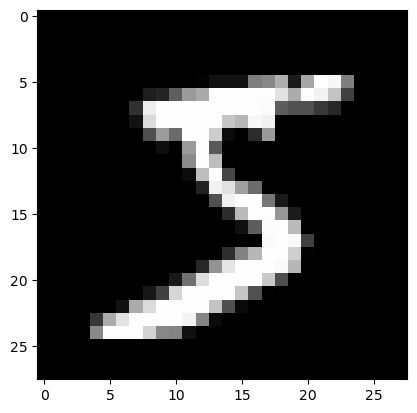

In [46]:
plt.imshow(x_train_np[0], cmap='gray')

Flatten the images(28,28)

In [47]:
x_train_np_flattened = x_train_np.reshape(x_train_np.shape[0], 28*28)
x_test_np_flattened = x_test_np.reshape(x_test_np.shape[0], 28*28)
x_train_np_flattened.shape, x_test_np_flattened.shape

((60000, 784), (10000, 784))

The tf.random.normal function generates values from a normal distribution (also known as a Gaussian distribution). By default, this distribution has a mean of 0 and a standard deviation of 1. This means that the values generated by tf.random.normal are centered around 0, with the majority of values falling within the range of -3 to 3, as per the properties of the normal distribution.

In [48]:
import tensorflow as tf

# Generate a tensor with normal distribution
tensor = tf.random.normal(shape=[1, 2])

# Convert the tensor to a NumPy array and print its values
print(tensor.numpy())


[[-0.3235397 -2.4797084]]


## Defining initial values of parameters

In [49]:
n_input = 784
n_hidden1 = 256
n_hidden2 = 256
n_output = 10

weights = {
#     'h1': tf.Variable(tf.random.normal(shape=[n_input, n_hidden1]), trainable=False), # sometimes, you do not wish to re-train some parameters in a layer
    'h1': tf.Variable(tf.random.normal(shape=[n_input, n_hidden1]), trainable=False),
    'h2': tf.Variable(tf.random.normal(shape=[n_hidden1, n_hidden2])),
    'output': tf.Variable(tf.random.normal(shape=[n_hidden2, n_output]))
}

biases = {
    'h1': tf.Variable(tf.random.normal(shape=[n_hidden1])),
    'h2': tf.Variable(tf.random.normal(shape=[n_hidden2])),
    'output': tf.Variable(tf.random.normal(shape=[n_output]))
}

## Forward Propagation

Apply Relu activation function on the hidden layers

In [50]:
# Convert weights and biases to float32 if necessary
weights = {k: tf.cast(v, tf.float32) for k, v in weights.items()}
biases = {k: tf.cast(v, tf.float32) for k, v in biases.items()}

In [51]:
def forward_propagation(x_input, weights, biases):
    # Ensure x_input is of type float32
    x_input = tf.cast(x_input, tf.float32)
    
    input_layer1 = tf.add(tf.matmul(x_input, weights['h1']), biases['h1'])  # Corrected tf.add call
    output_layer1 = tf.nn.relu(input_layer1)
    input_layer2 = tf.add(tf.matmul(output_layer1, weights['h2']), biases['h2'])  # Corrected tf.add call
    output_layer2 = tf.nn.relu(input_layer2)
    output = tf.add(tf.matmul(output_layer2, weights['output']), biases['output'])  # Corrected tf.add call
    return output

## Finding Cost using Cross-Entropy as the Cost Function

In [52]:
def compute_loss(pred, y_true_one_hot):
    cost_for_each_image = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels= y_true_one_hot) #logits are the predictions we have made
    cost = tf.reduce_mean(cost_for_each_image)
    return cost

## Minimizing cost using the Adam Optimizer [Back Propagation]

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [54]:
# Training step function
@tf.function
def train_step(x_train, y_train, weights, biases):
    with tf.GradientTape() as tape:
        pred = forward_propagation(x_train, weights, biases)
        loss = compute_loss(pred, y_train)
    gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
    optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))
    return loss

In [55]:
#instead of passing the entire dataset at once, pass it in batches for quick computations and better accuracy
batch_size = 100
num_samples = x_train_np_flattened.shape[0]
num_batches = int(np.ceil(num_samples / batch_size))  # Ensure we cover all samples
num_epochs = 30
for epoch in range(num_epochs):
    total_cost = 0
    for batch_index in range(num_batches):
        # Compute start and end indices for this batch
        start = batch_index * batch_size
        end = min((batch_index + 1) * batch_size, num_samples)
        
        # Extract batch data
        batch_x = x_train_np_flattened[start:end]
        batch_y = y_train_one_hot[start:end]
        
        # Perform a training step
        cost = train_step(batch_x, batch_y, weights, biases)
        total_cost += cost
    
    # Print total cost for the epoch
    print(f'Epoch {epoch + 1}, Total Cost: {total_cost}')
        

Epoch 1, Total Cost: 12509219.0
Epoch 2, Total Cost: 2885646.25
Epoch 3, Total Cost: 1688384.0
Epoch 4, Total Cost: 1032130.6875
Epoch 5, Total Cost: 705487.25
Epoch 6, Total Cost: 533713.5625
Epoch 7, Total Cost: 381935.5
Epoch 8, Total Cost: 326733.125
Epoch 9, Total Cost: 298708.8125
Epoch 10, Total Cost: 276019.71875
Epoch 11, Total Cost: 231693.515625
Epoch 12, Total Cost: 207431.96875
Epoch 13, Total Cost: 212717.015625
Epoch 14, Total Cost: 191016.578125
Epoch 15, Total Cost: 187153.9375
Epoch 16, Total Cost: 169644.390625
Epoch 17, Total Cost: 172586.28125
Epoch 18, Total Cost: 148137.984375
Epoch 19, Total Cost: 150639.578125
Epoch 20, Total Cost: 152840.515625
Epoch 21, Total Cost: 136474.125
Epoch 22, Total Cost: 146993.96875
Epoch 23, Total Cost: 113743.734375
Epoch 24, Total Cost: 132849.390625
Epoch 25, Total Cost: 126074.59375
Epoch 26, Total Cost: 115165.71875
Epoch 27, Total Cost: 128954.484375
Epoch 28, Total Cost: 114264.546875
Epoch 29, Total Cost: 126389.09375
Epoc

In [63]:
true_labels = tf.math.argmax(y_train_one_hot, axis=1) 
true_labels.numpy()

array([5, 0, 4, ..., 5, 6, 8], dtype=int64)

In [64]:
y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [65]:
pred = forward_propagation(x_train_np_flattened, weights, biases)
predictions = tf.math.argmax(pred, axis=1) #to find the index for each 60,000 samples, where the number is maximum
predictions

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([5, 0, 4, ..., 5, 6, 8], dtype=int64)>

In [66]:
#evaluating how many of the predictions match the true_labels
correct_predictions = tf.equal(predictions, true_labels)
correct_predictions.numpy()

array([ True,  True,  True, ...,  True,  True,  True])

In [67]:
correct_predictions = tf.cast(correct_predictions, tf.int32)
correct_predictions

<tf.Tensor: shape=(60000,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [68]:
total_correct_predictions = tf.reduce_sum(correct_predictions)
total_correct_predictions.numpy()

59105

In [69]:
training_score = total_correct_predictions.numpy() /  correct_predictions.shape[0]
training_score * 100

98.50833333333333